In [1]:
import sandy

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.linalg import svd
from scipy.sparse.linalg import svds

# Read covariance data from JEFF-3.3

In [5]:
cov = sandy.get_endf6_file("jeff_33", "xs", 922380).get_errorr(err=1, chi=False, nubar=False, mubar=False)["errorr33"].get_cov()

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
    If you want to process 0K cross sections use `temperature=0.1`.
    


In [6]:
u, s, vh = svd(cov.data.values, check_finite=False)

In [19]:
print(f"number of parameters: {s.size}")

number of parameters: 1440


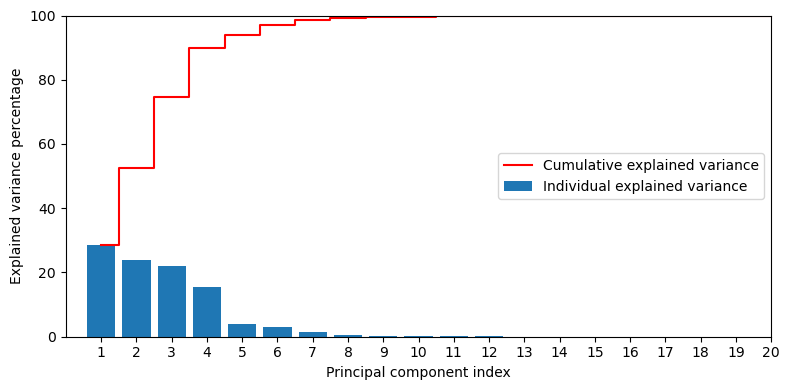

In [8]:
exp_var = (s / np.sum(s)) * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.bar(range(1, s.size+1), exp_var, align='center', label='Individual explained variance')
ax.step(range(1, s.size+1), cum_exp_var, where='mid', label='Cumulative explained variance', color='red')

ax.set(
    xlim=(0, 20),
    ylim=(0, 100),
    ylabel='Explained variance percentage',
    xlabel='Principal component index',
)
ax.set_xticks(ticks=list(range(1, 21)))
ax.legend(loc=5)
fig.tight_layout()

# Keep 99.9 % of the variance information

In [20]:
s_ = s[np.cumsum(s / np.sum(s)) * 100 < 99.9]
cov_ = u[:, :s_.size] @ np.diag(s_) @ u[:, :s_.size].T
cov_ = sandy.CategoryCov(cov_, index=cov.data.index, columns=cov.data.columns)
print(f"number of parameters reduced to: {s_.size}")

number of parameters reduced to: 12


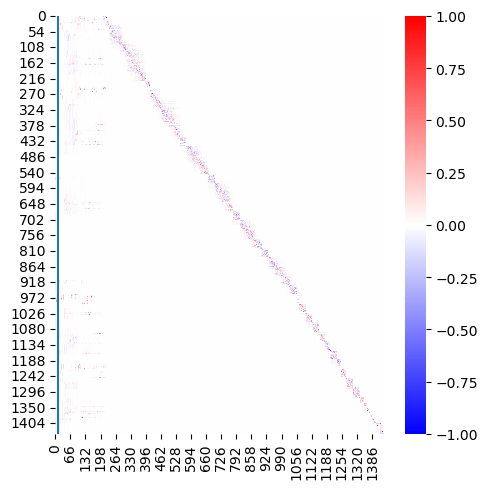

In [10]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
sns.heatmap(u, cmap="bwr", center=0, vmin=-1, vmax=1, ax=ax)
ax.axvline(s_.size)
fig.tight_layout()

## Original vs truncated covariance

In [11]:
std = cov.get_std().reset_index()
std["E"] = std["E"].apply(lambda x: x.left)
std["MT"] = std["MT"].astype('category')

std_ = cov_.get_std().reset_index()
std_["E"] = std_["E"].apply(lambda x: x.left)
std_["MT"] = std_["MT"].astype('category')

data = std.merge(std_, on=["MAT", "MT", "E"], suffixes=("_orig", "_cut"))
data["STD_rel_diff"] = (data.STD_cut / data.STD_orig - 1) * 100
data["STD_abs_diff"] = data.STD_cut - data.STD_orig

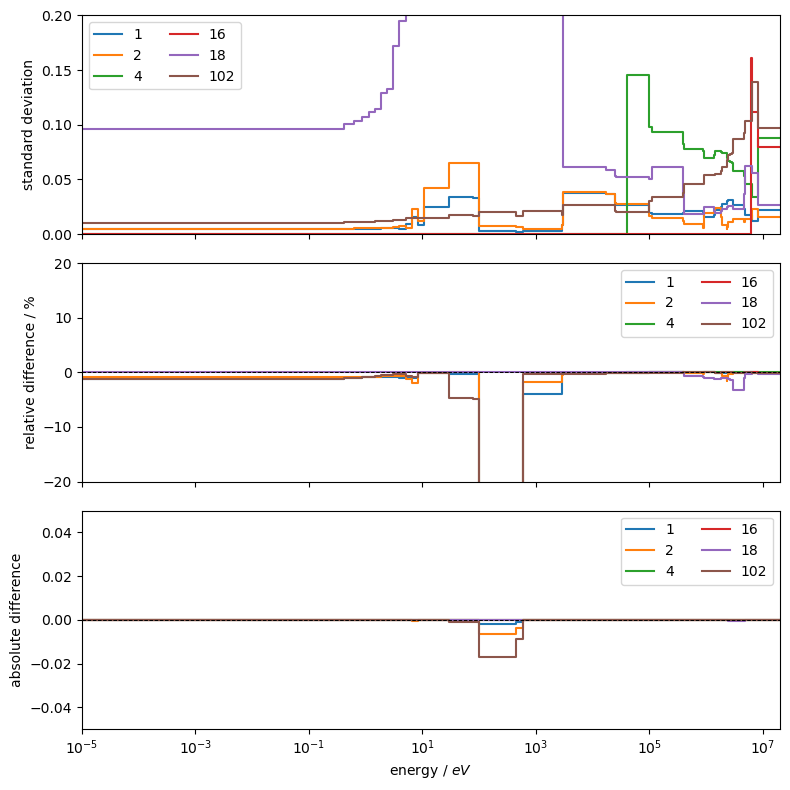

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), dpi=100, sharex=True)

ax = axs[0]
sns.lineplot(data=data, x="E", y="STD_orig", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(0, 0.20),
    xscale="log",
    ylabel="standard deviation",
)
ax.legend(ncol=2)

ax = axs[1]
sns.lineplot(data=data, x="E", y="STD_rel_diff", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(-20, 20),
    xscale="log",
    ylabel="relative difference / %",
)
ax.axhline(0, color='k', ls='--', lw=.7)
ax.legend(ncol=2)

ax = axs[2]
sns.lineplot(data=data, x="E", y="STD_abs_diff", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(-0.05, 0.05),
    xscale="log",
    ylabel="absolute difference",
    xlabel="energy / $eV$",
)
ax.axhline(0, color='k', ls='--', lw=.7)
ax.legend(ncol=2)

fig.tight_layout()

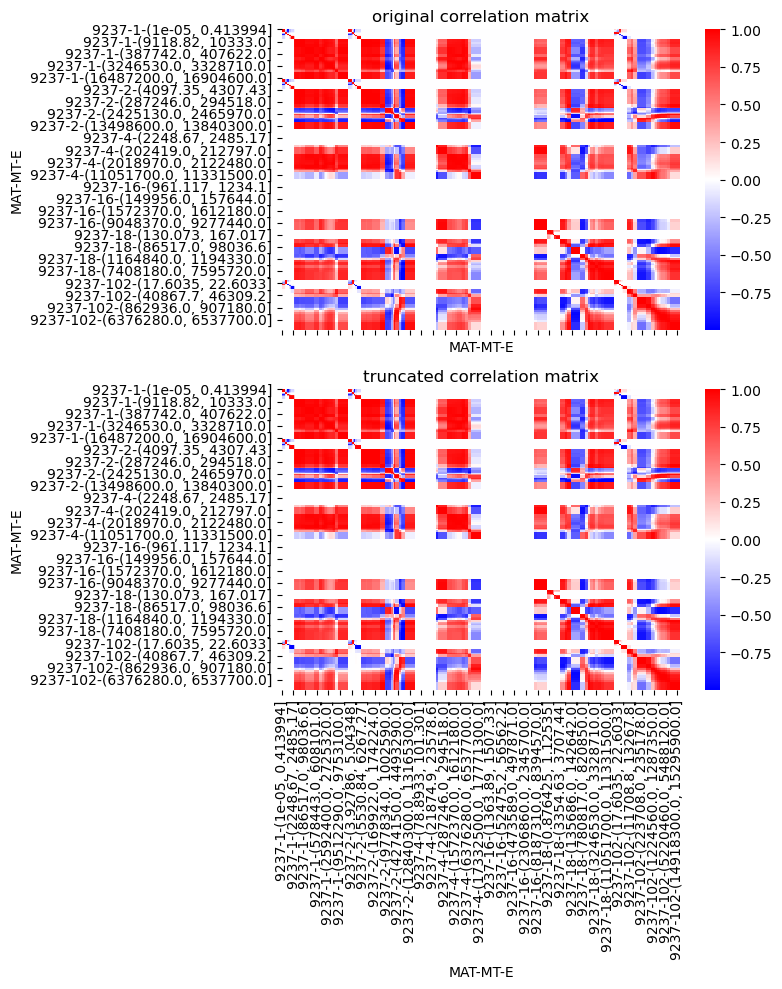

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), dpi=100, sharex=True, sharey=True)

ax = axs[0]
sns.heatmap(cov.get_corr().data, cmap="bwr", center=0, ax=ax)
ax.set_title("original correlation matrix")

ax = axs[1]
sns.heatmap(cov_.get_corr().data, cmap="bwr", center=0, ax=ax)
ax.set_title("truncated correlation matrix")

fig.tight_layout()

## Original vs sample covariance

In [14]:
nsmp = 1000
y = np.random.randn(s_.size, nsmp)
smp = u[:, :s_.size] @ np.diag(np.sqrt(s_)) @ y

In [16]:
smp = pd.DataFrame(np.sqrt(s_).reshape(-1, 1) * y).rename_axis("SMP", axis=1)
k = 33
with pd.ExcelWriter("file_test.xlsx") as writer:
    smp.to_excel(writer, index=False, sheet_name=f'MF{k}_SMP')
    pd.DataFrame(u).to_excel(writer, index=False, header=False, sheet_name=f'MF{k}_U')
    pd.Series(s_).to_excel(writer, index=False, header=False, sheet_name=f'MF{k}_U')

In [416]:
cov__ = sandy.CategoryCov(np.cov(smp), index=cov.data.index, columns=cov.data.columns)

In [417]:
std = cov.get_std().reset_index()
std["E"] = std["E"].apply(lambda x: x.left)
std["MT"] = std["MT"].astype('category')

std_ = cov__.get_std().reset_index()
std_["E"] = std_["E"].apply(lambda x: x.left)
std_["MT"] = std_["MT"].astype('category')

data = std.merge(std_, on=["MAT", "MT", "E"], suffixes=("_orig", "_cut"))
data["STD_rel_diff"] = (data.STD_cut / data.STD_orig - 1) * 100
data["STD_abs_diff"] = data.STD_cut - data.STD_orig

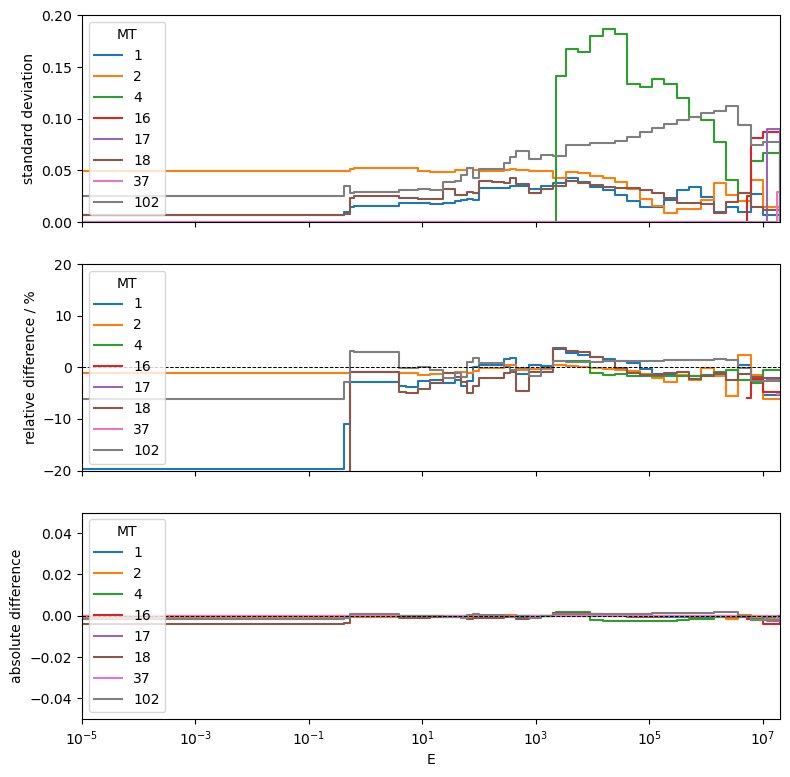

In [418]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), dpi=100, sharex=True)

ax = axs[0]
sns.lineplot(data=data, x="E", y="STD_orig", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(0, 0.20),
    xscale="log",
    ylabel="standard deviation",
)

ax = axs[1]
sns.lineplot(data=data, x="E", y="STD_rel_diff", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(-20, 20),
    xscale="log",
    ylabel="relative difference / %",
)
ax.axhline(0, color='k', ls='--', lw=.7)

ax = axs[2]
sns.lineplot(data=data, x="E", y="STD_abs_diff", hue="MT", ax=ax, drawstyle="steps-post")
ax.set(
    xlim=(1e-5, 2e7),
    ylim=(-0.05, 0.05),
    xscale="log",
    ylabel="absolute difference",
)
ax.axhline(0, color='k', ls='--', lw=.7)

fig.tight_layout()

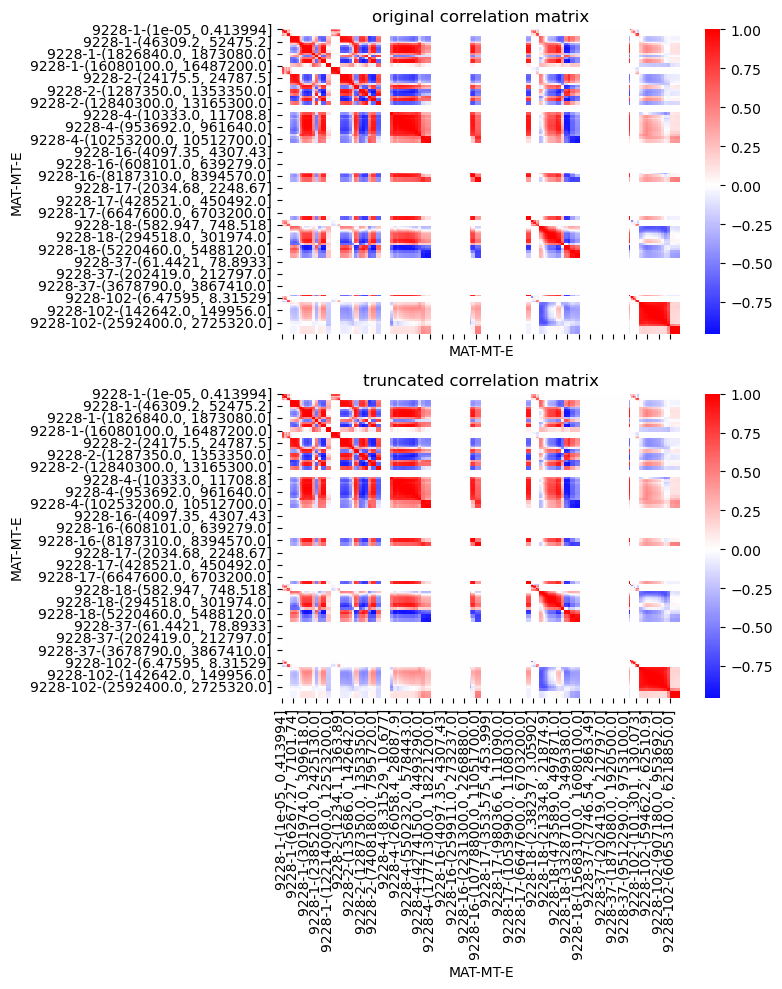

In [419]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), dpi=100, sharex=True, sharey=True)

ax = axs[0]
sns.heatmap(cov.get_corr().data, cmap="bwr", center=0, ax=ax)
ax.set_title("original correlation matrix")

ax = axs[1]
sns.heatmap(cov_.get_corr().data, cmap="bwr", center=0, ax=ax)
ax.set_title("truncated correlation matrix")

fig.tight_layout()